# Fundamentos de Ciência de Dados

Work made by:
- João António, nº 76558, joaoantonio@ua.pt, Mestrado em ciência de dados (9306)
- Tiago Freitas, nº 76748, tiagofreitas79@ua.pt, Mestrado em ciência de dados (9306)

## Organizações não governamentais de ambiente por 100 000 habitantes (N.º) por Localização geográfica (NUTS - 2013); Anual
https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&indOcorrCod=0008290&contexto=bd&selTab=tab2

### Base de dados: Nuts 2013

### Sinais convencionais
Sinais convencionais por ausência de valor
- `…`	Dado confidencial
- `-`	Dado nulo ou não aplicável
- `x`	Dado não disponível
- `o`	Dado inferior a metade do módulo da unidade utilizada
- `∞`	Infinito

Sinais convencionais adicionais ao valor
- `//` Dado preliminar
- `&`	Dado provisório
- `»`	Dado previsto
- `*`	Dado rectificado
- `§`	Desvio do padrão de qualidade/Coeficiente de variação elevado
- `“`	Estimativa
- `“E` Dado estimado pelo Eurostat
- `┴`	Quebra de série/comparabilidade
- `i`	Mais informação em anexo

## Sinais convencionais diversos
- `µ`	Média
- `=`	Igual
- `>`	Maior que
- `≥`	Maior ou igual
- `<`	Menor que
- `≤`	Menor ou igual
- `%`	Percentagem
- `‰`	Permilagem
- `∑`	Soma de
- `≠`	Diferente

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
%matplotlib inline

## Load INE Culturas

In [16]:
file_csv = "./data_FCD/ine_principais_culturas_agricolas.csv"

In [17]:
def load_ine_cultures(file_csv):
    df=pd.read_csv(file_csv,delimiter=";", encoding="latin-1", header=[4, 6], nrows=12, on_bad_lines="skip")    

    ## Drop Columns
    df.drop(labels=[0], inplace=True) # Drop first row
    df.drop(columns=df.columns[-1], inplace=True) # Drop last column
    
    df.drop(labels=[9,11], inplace=True) # Drop repeated Açores and Madeira rows
    
    ## Reset of the Index as Region with just the region codes
    df['Region_split'] = df[df.columns[0]].apply(lambda x : str(x).rsplit(sep = ':', maxsplit=1))
    df['Region']= df['Region_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
    df['Region_names']= df['Region_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
    region_names = df["Region_names"].to_list()
    df.set_index("Region", inplace=True)
    columns_to_rem = [0, -1, -2] # Remove Unnamed: 0_level_1(1st), Region_split(last) and Region_names(before last) columns
    df.drop(df.columns[columns_to_rem], axis=1, inplace=True)
    
    ## Changed regions names to just one word per region to make it easier for graphical representations later
    for k_ind, k in enumerate(region_names):
        k_split = k.split(" ")
        if len(k_split) > 1:
            region_names[k_ind] = k_split[-1]
    
    ## Redo the Headers, from unnamed to the year
    c0 = df.columns.get_level_values(0).to_series()
    c1 = list(df.columns.get_level_values(1).to_series())
    c0 = c0.mask(lambda c: c.str.startswith("Unnamed")).ffill()
    df.columns = [c0, c1]
    
    ## Bringing the year to the index
    df = df.stack(level=0)
    df.index.names=['Region', 'year']
    
    ## Replacing 'x', 'x x', '- -' for their respective value
    df.replace({'x':np.nan,'x x':np.nan,'- -':0,'nan':np.nan},inplace=True)
    
    ## Replacing provisional data 
    for column in df:
        df[column]=df[column].map(lambda x: str(x).rstrip(' &'))
        df[column]=df[column].map(lambda x: str(x).rstrip(' *'))
        
    # This method turns data to stringd so we have to turn the data back to numeric
    for column in df:
        df[column]=pd.to_numeric(df[column],'coerce')
    
    return df, region_names

In [18]:
data, region_names = load_ine_cultures(file_csv)
data

Abacate  Abóbora (inclui butternut)  Alface  Alho  Alho-porro  \
Region year                                                                  
PT     1986      NaN                         NaN     NaN   NaN         NaN   
       1987      NaN                         NaN     NaN   NaN         NaN   
       1988      NaN                         NaN     NaN   NaN         NaN   
       1989      NaN                         NaN     NaN   NaN         NaN   
       1990      NaN                         NaN     NaN   NaN         NaN   
...              ...                         ...     ...   ...         ...   
3      2017      NaN                         NaN     NaN   NaN         NaN   
       2018      0.0                         NaN     NaN   NaN         NaN   
       2019   8243.0                         NaN     NaN   NaN         NaN   
       2020   9164.0                         NaN     NaN   NaN         NaN   
       2021   9726.0                         NaN     NaN   NaN         NaN   

             Ameixa  Amoras  Amêndoa  Ananás  Arroz  ...  Trigo  Trigo duro  \
Region year                                          ...                      
PT     1986    6006     NaN      848     NaN   4463  ...   1630        1250   
       1987    6266     NaN      996     NaN   4322  ...   1694        1355   
       1988    5173     NaN      506     NaN   4266  ...   1380         789   
       1989    5769     NaN     1237     NaN   4290  ...   1915        1197   
       1990    6436     NaN     1098     NaN   4614  ...   1429        1270   
...             ...     ...      ...     ...    ...  ...    ...         ...   
3      2017    7529     NaN        0     0.0      0  ...   1986           0   
       2018    7760     0.0        0     0.0      0  ...   1986           0   
       2019    8339     0.0        0     0.0      0  ...   2002           0   
       2020    5880     0.0        0     0.0      0  ...   1988           0   
       2021    5018     0.0        0     0.0      0  ...   2002           0   

             Trigo mole  Triticale  Uva de mesa  Uva para vinho  \
Region year                                                       
PT     1986        1669       1405         6720            4122   
       1987        1727       1410         7702            5765   
       1988        1425       1237         3179            1965   
       1989        1977       1666         5517            3963   
       1990        1445       1244         5740            5806   
...                 ...        ...          ...             ...   
3      2017        1986          0         7881            5490   
       2018        1986          0         7881            4386   
       2019        2002          0         7881            6224   
       2020        1988          0         7883            5980   
       2021        2002          0         7883            6474   

             Uva para vinho (DOP)  Uva para vinho (IGP)  \
Region year                                               
PT     1986                   NaN                   NaN   
       1987                   NaN                   NaN   
       1988                   NaN                   NaN   
       1989                   NaN                   NaN   
       1990                   NaN                   NaN   
...                           ...                   ...   
3      2017                   NaN                   NaN   
       2018                   NaN                   NaN   
       2019                   NaN                   NaN   
       2020                   NaN                   NaN   
       2021                   NaN                   NaN   

             Uva para vinho (Vinhos sem certificação)  Vinha  
Region year                                                   
PT     1986                                       NaN   4199  
       1987                                       NaN   5824  
       1988                                       NaN   2002  
       1989    

<Figure size 1600x800 with 0 Axes>

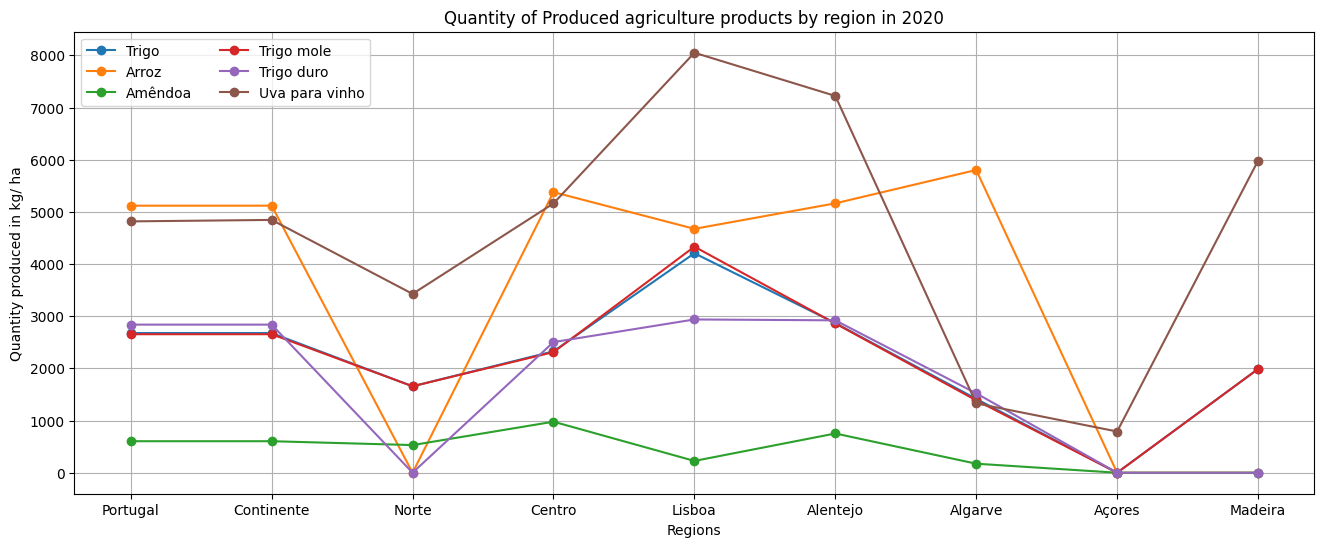

In [19]:
plt.figure(figsize=(16, 8))
df_2020=data.xs("2020", level=1)

df_2020.columns
## Obtain index of Specific Products draw those index on plot
labels_to_plot = ["Trigo", "Arroz", "Amêndoa", "Trigo mole", "Trigo duro", "Uva para vinho"]
index_to_plot = [list(df_2020.columns).index(product) for product in labels_to_plot]

# filter_col = ["Trigo", "Trigo duro", "Ananás", "Amêndoa",]
df_2020[df_2020.columns[index_to_plot]].plot(figsize=(16, 6), marker="o")
plt.title("Quantity of Produced agriculture products by region in 2020")
plt.xlabel("Regions")
plt.ylabel("Quantity produced in kg/ ha")
plt.legend(loc="upper left", ncol=2)
plt.grid()
plt.xticks(range(len(region_names)), region_names)
plt.show()
# plt.savefig("Production_2020.png")

## IPMA Notebooks
Note that the Structure of pages inside the Excel is given by:
- Shet 0 is metadata
- Shet 1 is tmin
- Shet 2 is tmax
- Shet 3 is Pluviosity

In [20]:
# Global Functions have the name in full capslock to respect pep8
# 1st Code is of the region, the second is the name of the IPMA
MAP_REGIONS_EXCEL = {
    "Norte": [11, 11],
    "Centro": [16, 132],
    "Lisboa": [17, 320],
    "Alentejo": [18, 571],
    "Algarve": [15, 554],
    "Açores": [2, 360],
    "Madeira": [3, 522],
}
IPMA_COLUMNS = ["Tmin", "Tmax", "Prec", "TmaxA", "TminA", "Prec_max", "Prec_min"]

In [21]:
def add_extra_col(meteo_coln, sheet_number):
    sheet_number += 1  # So that 1 is the Tmin, 2 is the Tmax and 3 is the precipitation
    index_describe = 2  # Mean

    if meteo_coln == "TmaxA":
        # Meaning T Max Ablsolute, so the real maximum temperature that we obtained that year
        index_describe = 7  # Max
        sheet_number = 2  # Tmax

    elif meteo_coln == "TminA":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 3  # Min
        sheet_number = 1  # Tmin

    elif meteo_coln == "Prec_min":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 3  # Min
        sheet_number = 3  # Precipitation Sheet

    elif meteo_coln == "Prec_max":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 7  # Max
        sheet_number = 3  # Precipitation Sheet

    for region, codes in MAP_REGIONS_EXCEL.items():
        meteo2 = pd.read_excel(
            f"./data_FCD/IPMA/{codes[1]}-tx-tn-prec.xlsx",
            sheet_name=sheet_number,
        )
        meteo2.dropna(axis=0, how="any", inplace=True)

        #Obtain only years after 1986
        meteo2 = meteo2[meteo2.year > 1986]
        meteo2.set_index("year", inplace=True)
        meteo2.index.names = ["Region"]
        
        # use teh Describe that gives mean (index 2), max (index 7) and min (index 3)
        data_prec = meteo2.transpose().describe()
        index_names_arr = data_prec.index.values
        
        #Rename that column to region and drop the others
        index_names_arr[index_describe] = codes[0]
        for k_name in index_names_arr:
            if k_name != codes[0]:
                data_prec.drop(index=k_name, inplace=True)
        
        years_list = data_prec.keys()
        header = [years_list, [meteo_coln] * len(years_list)]
        data_prec.columns = header
        
        data_f = (
            data_prec
            if region == list(MAP_REGIONS_EXCEL.keys())[0]
            else pd.concat([data_f, data_prec])
        )
    return data_f


In [22]:
def load_ipma():
    ipma = {
        type_data: add_extra_col(type_data, k)
        for k, type_data in enumerate(IPMA_COLUMNS)
    }
    ## Make all the concats at the same time to save time
    meteo = pd.concat([ipma[k] for k in IPMA_COLUMNS], axis=1)
    # meteo["T_range"] = meteo["TmaxA"] - meteo["TminA"]
    meteo= meteo.stack(level=0)
    meteo.index.names = ["Region", "Year"]
    return meteo.reindex(sorted(meteo.columns), axis=1)

In [23]:
meteo = load_ipma()
meteo

## Correlation between our columns of Meterologic Data
Here we can see a high correlation between `Prec` and `Prec_max` and between the `Tmax`and `Tmin` and `TminA` we can also see some correlation

In [ ]:
# A pairplot between all the meteo data that we are obtaining
sns.pairplot(meteo)
plt.show()

In [ ]:
filter_col = ["Trigo", "Amêndoa"]

year = range(1986, 2022)
df_alentejo_trig_amend = {
}
for k_col, col in enumerate(filter_col):
    if col not in df_alentejo_trig_amend:
        df_alentejo_trig_amend[col] = []
    for elem in data[col]["18"]:
        df_alentejo_trig_amend[col].append(elem)

meteo_data = {}
meteo_region=meteo.xs(18)
col_to_draw = ["Prec_max"]
for k_col, col in enumerate(col_to_draw):
    if col not in meteo_data:
        meteo_data[col] = []
    for elem in meteo_region[col]:
        meteo_data[col].append(elem)
    meteo_data["year"] = meteo_region[col].index
    
for key in df_alentejo_trig_amend:
    df_alentejo_trig_amend[key] = MaxAbsScaler().fit_transform(np.array(df_alentejo_trig_amend[key]).reshape(-1, 1))

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
for key in df_alentejo_trig_amend:
    ax.plot(year, df_alentejo_trig_amend[key], label=key, marker="o")
ax2.plot(meteo_data["year"], meteo_data["Prec_max"], color="red", marker="o")
ax2.set_xlim([1984, 2022])
ax.set_xlim([1984, 2022])
ax.set_ylabel("Quantity produced Normalized with min max")
ax2.set_ylabel("Max Precipitation")
ax2.grid()
ax.grid()
ax.set_title("Quantity of Trigo products by year in the north")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

## Study of the Correlation between the Meteorologic Data and the production of Trigo for the North of Portugal
To do this we have first selected only the years that are common to both datasets, and then we have ploted the correlation

In [ ]:
## TODO finish the Correlation matrix, maybe change the nan to zero, to make this plot
meteo_region = meteo.xs(11)
data_region = data.xs("11")
index_to_plot= ["Trigo"]

index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(2019)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index("2019")
data_region = data_region[index_to_plot].iloc[range(index_min,index_max)]


f,ax = plt.subplots(figsize=(12, 10))
cols = list(meteo_region.columns)
cols.append("Trigo")
cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()
# cols = cols.drop('Transported')
print(cols)

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
for key in df_alentejo_trig_amend:
    ax.plot(year, df_alentejo_trig_amend[key], label=key, marker="o")
ax2.plot(data_region, meteo_region, color="red", marker="o")
ax2.set_xlim([1984, 2022])
ax.set_xlim([1984, 2022])
ax.set_ylabel("Quantity produced Normalized with min max")
ax2.set_ylabel("Max Precipitation")
ax2.grid()
ax.grid()
ax.set_title("Quantity of Trigo products by year in the north")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

Just by evaluating the graph above we can see that `Prec_min` was the one that had a highest correlation with `Trigo`, so the higher the minimum of precipitation the higher the production of Trigo.